In [ ]:
!pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=62abdb93988135d11867c8f3bac0d70a4df7c23af137fa511e3f64e4879a769e
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [ ]:
import numpy as np
import random
import cv2
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [ ]:
# Set paths to root, train, test and validation directories
_rootDir = '../input/braintumor/Brain/'
#os.listdir(_rootDir)
_trainDir = _rootDir + 'train/'
_valDir = _rootDir + 'validation/'
_testDir = _rootDir + 'test/'

In [ ]:
# Function to preprocess and store images and labels
def load(paths, verbose=-1):
    '''
        return:
            _imageList: A list of Images
            labels: A list of corresponding Labels
        args:
            paths: Path to main directory 
            * Must contain images belonging to a class as a single folder
    '''
    _imageList = list()
    _labelList = list()
    
    for (i, _imgPath) in enumerate(paths):
        
        img = cv2.imread(_imgPath, cv2.IMREAD_GRAYSCALE)
        # Set the desired height and weight of image data
        _dimensions = (32, 32)
        
        # resize image
        _image = cv2.resize(img, _dimensions, interpolation = cv2.INTER_AREA)
        numpyImage = np.array(_image).flatten()
        
        # rescale the image
        mupyImage = numpyImage/255
        label = _imgPath.split(os.path.sep)[-2]
        #print(label)
        
        _imageList.append(mupyImage)
        _labelList.append(label)
        
    # return a tuple of the _imageList and _labelList
    return _imageList, _labelList

In [ ]:
def one_hot_encoding(path):
    _path = list(paths.list_images(path))
    _data, _labelList = load(_path, verbose=10000)
    _lblzr = LabelBinarizer()
    _labels = _lblzr.fit_transform(_labelList)
    
    return _data, _labels

In [ ]:
# Preprocess training data
_trainX, _trainY = one_hot_encoding(_trainDir)
#print(len(_trainX))
#print(type(_trainY))

In [ ]:
# Preprocess validation and test data
_valX, _valY = one_hot_encoding(_valDir)

_testX, _testY = one_hot_encoding(_testDir)

In [ ]:
def create_clients(image_list, label_list, num_clients):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    _clientNames = []
    for i in range(num_clients):
        _client = '{}_{}'.format('client', i+1)
        _clientNames.append(_client)

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)

    #shard data and place at each client
    size = len(data)//num_clients
    
    _clientShards =[]
    for i in range(0, size*num_clients, size):
        _shard = data[i: i+size]
        _clientShards.append(_shard)
    
    #number of clients must equal number of shards
    if len(_clientShards) == len(_clientNames):
        _clientDict = {}
        for i in range(len(_clientNames)):
            _clientDict[_clientNames[i]] = _clientShards[i]
        return _clientDict
    else:
        return 0
    

In [ ]:
clients = create_clients(_trainX, _trainY, num_clients = 7)

In [ ]:
def batch_data(data_shard, bs=64):
    
    # Create tensorflow datasets from each client's data shards
    data, label = zip(*data_shard)
    #print("----------------"+str(type(data)))
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [ ]:
# Create batches for training data
clients_batched = dict()

for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)

In [ ]:
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((_testX, _testY)).batch(len(_testY))

#process and batch the test set  
val_batched = tf.data.Dataset.from_tensor_slices((_valX, _valY)).batch(len(_valY))

In [ ]:
# Define the hyperparameters
lr = 0.01 
_globalEpochs = 200
loss='categorical_crossentropy'
metrics = ['accuracy'] 
optimizer = SGD(lr=lr, 
                decay=lr / _globalEpochs, 
                momentum=0.9
               )   
activationFunction = "relu"

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# Class for model architecture
class MLP:
    @staticmethod
    def _buildModel(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        
        #print(model.summary())
        return model

In [ ]:
def _globalAverageWeights(_localWeightList):
    _averageWeights = list()
    
    for _list in zip(*_localWeightList):
        _sum = tf.math.reduce_sum(_list, axis=0)
        _averageWeights.append(_sum)
        
    return _averageWeights

In [ ]:
def _getScalingFactor(_trainData, _clientName, _batchSize):
    
    _clients = list(_trainData.keys())
    
    #first calculate the total training data points across clinets
    _gblLength = list()
    _gblCount = 0
    
    for client in _clients:
        _length = tf.data.experimental.cardinality(_trainData[client]).numpy()
        _gblLength.append(_length)
        
    _gblCount = sum(_gblLength) * _batchSize

    # get the total number of data points held by a client
    _lclCount = tf.data.experimental.cardinality(_trainData[_clientName]).numpy()*_batchSize
    
    return _lclCount/_gblCount

In [ ]:
def _scaleWeights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final


In [ ]:
def test_model(X_test, Y_test,  model, comm_round):
    
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    logits = model.predict(X_test)

    loss = cce(Y_test, logits)

    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [ ]:
def _trainModel(_epochStep, _shallowLayers, _totalLayers):
    #initialize global model
    _globalObject = MLP()
    globalModel = _globalObject._buildModel(1024, 4)

    _globalAccuracy = list()
    _globalLoss = list()
    
    shallow_index = 2 * _shallowLayers
    total_index = 2 * _totalLayers
    #commence global training loop
    for _gEpoch in range(_globalEpochs):

        # get the global model's weights - will serve as the initial weights for all local models
        _globalWeights = globalModel.get_weights()

        #print(type(global_weights))
        global_deep_weights = _globalWeights[shallow_index:total_index]

        #initial list to collect local model weights after scalling
        _localWeightList = list()

        #randomize client data - using keys
        client_names= list(clients_batched.keys())
        random.shuffle(client_names)
        factor = 0
        #loop through each client and create new local model
        for client in client_names:
            _localObject = MLP()
            localModel = _localObject._buildModel(1024, 4)
            localModel.compile(loss=loss, 
                          optimizer=optimizer, 
                          metrics=metrics)


            #set local model weight to the weight of the global model
            localModel.set_weights(_globalWeights)

            #fit local model with client's data
            localModel.fit(clients_batched[client], epochs=10, verbose=0)
            lm = localModel.get_weights()

            if _gEpoch%_epochStep != 0:
                shallow_weights = lm[0:shallow_index]
                deep_weights = lm[shallow_index:total_index]
                comm_weights = shallow_weights
            else:
                comm_weights = lm

            #scale the model weights and add to list
            _scalingFactor = _getScalingFactor(clients_batched, client, 64)
            scaledWeights = _scaleWeights(comm_weights, _scalingFactor)

            #scaled_weights = _scaleLocalWeights(clients_batched,comm_weights, 64, client)
            _localWeightList.append(scaledWeights)
            factor = _scalingFactor

            #clear session to free memory after each communication round
            K.clear_session()

        globalScaledWeights = _scaleWeights(global_deep_weights, factor)

        if _gEpoch%_epochStep != 0:
            final_weights = list()
            for i in range(len(_localWeightList)):
                _weight = _localWeightList[i] + globalScaledWeights
                final_weights.append(_weight)

        else:
            final_weights = _localWeightList

        #to get the average over all the local model, we simply take the sum of the scaled weights
        #average_weights = sum_scaled_weights(scaled_local_weight_list)
        average_weights = _globalAverageWeights(final_weights)

        #update global model 
        globalModel.set_weights(average_weights)

        #test global model and print out metrics after each communications round

        for(X_val, Y_val) in val_batched:
            global_acc, global_loss = test_model(X_val, Y_val, globalModel, _gEpoch)
            _globalAccuracy.append(global_acc)
            _globalLoss.append(global_loss)
        
    return globalModel,_globalAccuracy, _globalLoss
        

In [ ]:
def _visualise(_model,_acc, _loss):
    plt.plot(_acc)
    plt.plot(_loss)
    plt.title('Global Accuracy and Loss')
    plt.ylabel('Accuracy/Loss')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'loss'], loc='upper left')
    plt.show()

CASE 1: 
* Sharing deep weights every 5th epoch, 1 - shallow and 5 deep layers

In [ ]:
_case1Model, _case1Accuracy, _case1Loss  = _trainModel(5, 1, 6) 

In [ ]:
_visualise(_case1Model, _case1Accuracy, _case1Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case1Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

CASE 2:
* Sharing deep weights every 10th epoch, 1 shallow and 5 deep layers

In [ ]:
_case2Model, _case2Accuracy, _case2Loss  = _trainModel(10, 1, 6) 

In [ ]:
_visualise(_case2Model, _case2Accuracy, _case2Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case2Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

CASE 3:
* Sharing deep weights every epoch, 1 shallow and 5 deep layers

In [ ]:
_case3Model, _case3Accuracy, _case3Loss  = _trainModel(1, 1, 6) 

In [ ]:
_visualise(_case3Model, _case3Accuracy, _case3Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case3Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

CASE 4:
* Sharing deep weights every 5th epoch, 3 shallow and 3 deep layers

In [ ]:
_case4Model, _case4Accuracy, _case4Loss  = _trainModel(5, 3, 6) 

In [ ]:
_visualise(_case4Model, _case4Accuracy, _case4Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case4Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

CASE 5:
* Sharing deep weights every 10th epoch, 3 shallow and 3 deep layers

In [ ]:
_case5Model, _case5Accuracy, _case5Loss  = _trainModel(10, 3, 6) 

In [ ]:
_visualise(_case5Model, _case5Accuracy, _case5Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case5Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

CASE 6:
* Sharing deep weights every epoch, 3 shallow and 3 deep layers

In [ ]:
_case6Model, _case6Accuracy, _case6Loss  = _trainModel(1, 3, 6) 

In [ ]:
_visualise(_case6Model, _case6Accuracy, _case6Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case6Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

CASE 7:
* Sharing deep weights every 5th epoch, 4 shallow and 2 deep layers

In [ ]:
_case7Model, _case7Accuracy, _case7Loss  = _trainModel(5, 4, 6) 

comm_round: 0 | global_acc: 58.333% | global_loss: 1.19452702999115
comm_round: 1 | global_acc: 64.583% | global_loss: 1.1370614767074585
comm_round: 2 | global_acc: 70.833% | global_loss: 1.1045223474502563
comm_round: 3 | global_acc: 75.000% | global_loss: 1.0823628902435303
comm_round: 4 | global_acc: 70.833% | global_loss: 1.0566118955612183
comm_round: 5 | global_acc: 79.167% | global_loss: 0.9680692553520203
comm_round: 6 | global_acc: 81.250% | global_loss: 0.9542839527130127
comm_round: 7 | global_acc: 79.167% | global_loss: 0.9663564562797546
comm_round: 8 | global_acc: 81.250% | global_loss: 0.9535140991210938
comm_round: 9 | global_acc: 79.167% | global_loss: 0.9413338303565979
comm_round: 10 | global_acc: 87.500% | global_loss: 0.901416540145874
comm_round: 11 | global_acc: 87.500% | global_loss: 0.8930686116218567
comm_round: 12 | global_acc: 89.583% | global_loss: 0.8737030625343323
comm_round: 13 | global_acc: 89.583% | global_loss: 0.8703732490539551
comm_round: 14 | gl

2022-06-12 22:00:24.506886: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


comm_round: 44 | global_acc: 91.667% | global_loss: 0.8217266201972961
comm_round: 45 | global_acc: 91.667% | global_loss: 0.8226307034492493
comm_round: 46 | global_acc: 91.667% | global_loss: 0.8216452598571777
comm_round: 47 | global_acc: 91.667% | global_loss: 0.8220913410186768
comm_round: 48 | global_acc: 91.667% | global_loss: 0.8234249949455261
comm_round: 49 | global_acc: 91.667% | global_loss: 0.8219184875488281
comm_round: 50 | global_acc: 91.667% | global_loss: 0.8227316737174988
comm_round: 51 | global_acc: 91.667% | global_loss: 0.8210939764976501
comm_round: 52 | global_acc: 91.667% | global_loss: 0.8226192593574524
comm_round: 53 | global_acc: 91.667% | global_loss: 0.8216888904571533
comm_round: 54 | global_acc: 91.667% | global_loss: 0.822319507598877
comm_round: 55 | global_acc: 91.667% | global_loss: 0.8230730891227722
comm_round: 56 | global_acc: 91.667% | global_loss: 0.8227090835571289
comm_round: 57 | global_acc: 91.667% | global_loss: 0.8229478001594543
comm_ro

2022-06-12 22:02:31.950030: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


comm_round: 61 | global_acc: 91.667% | global_loss: 0.8223244547843933
comm_round: 62 | global_acc: 91.667% | global_loss: 0.8224799036979675
comm_round: 63 | global_acc: 91.667% | global_loss: 0.8223671317100525
comm_round: 64 | global_acc: 91.667% | global_loss: 0.822767436504364
comm_round: 65 | global_acc: 91.667% | global_loss: 0.8219919204711914
comm_round: 66 | global_acc: 91.667% | global_loss: 0.8220016360282898
comm_round: 67 | global_acc: 91.667% | global_loss: 0.822066068649292
comm_round: 68 | global_acc: 91.667% | global_loss: 0.8219321370124817
comm_round: 69 | global_acc: 91.667% | global_loss: 0.8219074606895447
comm_round: 70 | global_acc: 91.667% | global_loss: 0.8225834965705872
comm_round: 71 | global_acc: 91.667% | global_loss: 0.8223597407341003
comm_round: 72 | global_acc: 91.667% | global_loss: 0.8219740986824036
comm_round: 73 | global_acc: 91.667% | global_loss: 0.8218860626220703
comm_round: 74 | global_acc: 91.667% | global_loss: 0.8220017552375793
comm_rou

2022-06-12 22:10:32.779093: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


comm_round: 129 | global_acc: 91.667% | global_loss: 0.8188632130622864
comm_round: 130 | global_acc: 91.667% | global_loss: 0.8185623288154602
comm_round: 131 | global_acc: 91.667% | global_loss: 0.8185300827026367
comm_round: 132 | global_acc: 91.667% | global_loss: 0.8183820247650146
comm_round: 133 | global_acc: 91.667% | global_loss: 0.8186047673225403
comm_round: 134 | global_acc: 91.667% | global_loss: 0.8184101581573486
comm_round: 135 | global_acc: 91.667% | global_loss: 0.8186378479003906
comm_round: 136 | global_acc: 91.667% | global_loss: 0.8183566927909851
comm_round: 137 | global_acc: 91.667% | global_loss: 0.8184054493904114
comm_round: 138 | global_acc: 91.667% | global_loss: 0.818422257900238
comm_round: 139 | global_acc: 91.667% | global_loss: 0.8183725476264954
comm_round: 140 | global_acc: 91.667% | global_loss: 0.8187527656555176
comm_round: 141 | global_acc: 91.667% | global_loss: 0.8185210227966309
comm_round: 142 | global_acc: 91.667% | global_loss: 0.8181900978

2022-06-12 22:13:16.163786: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


comm_round: 151 | global_acc: 91.667% | global_loss: 0.8178645968437195
comm_round: 152 | global_acc: 91.667% | global_loss: 0.8178722262382507
comm_round: 153 | global_acc: 91.667% | global_loss: 0.8177310824394226
comm_round: 154 | global_acc: 91.667% | global_loss: 0.8176997303962708
comm_round: 155 | global_acc: 91.667% | global_loss: 0.8179283142089844
comm_round: 156 | global_acc: 91.667% | global_loss: 0.8177053928375244
comm_round: 157 | global_acc: 91.667% | global_loss: 0.8177096247673035
comm_round: 158 | global_acc: 91.667% | global_loss: 0.8177292943000793
comm_round: 159 | global_acc: 91.667% | global_loss: 0.8178530335426331
comm_round: 160 | global_acc: 91.667% | global_loss: 0.8176834583282471
comm_round: 161 | global_acc: 91.667% | global_loss: 0.8175287246704102
comm_round: 162 | global_acc: 91.667% | global_loss: 0.8174455761909485
comm_round: 163 | global_acc: 91.667% | global_loss: 0.8174454569816589
comm_round: 164 | global_acc: 91.667% | global_loss: 0.817525625

2022-06-12 22:17:36.801334: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


comm_round: 188 | global_acc: 91.667% | global_loss: 0.8168158531188965
comm_round: 189 | global_acc: 91.667% | global_loss: 0.8166658282279968
comm_round: 190 | global_acc: 91.667% | global_loss: 0.8166708946228027
comm_round: 191 | global_acc: 91.667% | global_loss: 0.8166453242301941
comm_round: 192 | global_acc: 91.667% | global_loss: 0.8165356516838074
comm_round: 193 | global_acc: 91.667% | global_loss: 0.8166356086730957
comm_round: 194 | global_acc: 91.667% | global_loss: 0.8163051605224609
comm_round: 195 | global_acc: 91.667% | global_loss: 0.8166168332099915
comm_round: 196 | global_acc: 91.667% | global_loss: 0.8164315223693848
comm_round: 197 | global_acc: 91.667% | global_loss: 0.8163185119628906
comm_round: 198 | global_acc: 91.667% | global_loss: 0.8163846135139465
comm_round: 199 | global_acc: 91.667% | global_loss: 0.8161458969116211


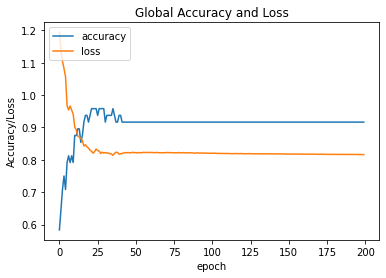

In [ ]:
_visualise(_case7Model, _case7Accuracy, _case7Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case7Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 95.249% | global_loss: 0.7911739945411682


CASE 8:
* Sharing deep weights every 10th epoch, 4 shallow and 2 deep layers

In [ ]:
_case8Model, _case8Accuracy, _case8Loss  = _trainModel(10, 4, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.3781198263168335
comm_round: 1 | global_acc: 25.000% | global_loss: 1.373278021812439
comm_round: 2 | global_acc: 31.250% | global_loss: 1.3656307458877563
comm_round: 3 | global_acc: 31.250% | global_loss: 1.3505668640136719
comm_round: 4 | global_acc: 31.250% | global_loss: 1.3294872045516968
comm_round: 5 | global_acc: 33.333% | global_loss: 1.3034900426864624
comm_round: 6 | global_acc: 37.500% | global_loss: 1.2747031450271606
comm_round: 7 | global_acc: 39.583% | global_loss: 1.2528014183044434
comm_round: 8 | global_acc: 43.750% | global_loss: 1.232826828956604
comm_round: 9 | global_acc: 52.083% | global_loss: 1.2156449556350708
comm_round: 10 | global_acc: 64.583% | global_loss: 1.1825050115585327
comm_round: 11 | global_acc: 64.583% | global_loss: 1.1658265590667725
comm_round: 12 | global_acc: 64.583% | global_loss: 1.1550780534744263
comm_round: 13 | global_acc: 64.583% | global_loss: 1.1458790302276611
comm_round: 14 | g

2022-06-12 22:25:10.966397: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


comm_round: 36 | global_acc: 85.417% | global_loss: 0.9966840744018555
comm_round: 37 | global_acc: 85.417% | global_loss: 0.9883671402931213
comm_round: 38 | global_acc: 85.417% | global_loss: 0.9955442547798157
comm_round: 39 | global_acc: 85.417% | global_loss: 0.9847140312194824
comm_round: 40 | global_acc: 83.333% | global_loss: 0.9817351698875427
comm_round: 41 | global_acc: 83.333% | global_loss: 0.9760381579399109
comm_round: 42 | global_acc: 85.417% | global_loss: 0.9741363525390625
comm_round: 43 | global_acc: 83.333% | global_loss: 0.9758369326591492
comm_round: 44 | global_acc: 85.417% | global_loss: 0.9709489941596985
comm_round: 45 | global_acc: 83.333% | global_loss: 0.966401994228363
comm_round: 46 | global_acc: 83.333% | global_loss: 0.9660300612449646
comm_round: 47 | global_acc: 81.250% | global_loss: 0.9676964282989502
comm_round: 48 | global_acc: 85.417% | global_loss: 0.9601829648017883
comm_round: 49 | global_acc: 87.500% | global_loss: 0.9584363102912903
comm_ro

2022-06-12 22:44:34.614872: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


comm_round: 195 | global_acc: 89.583% | global_loss: 0.8580480217933655
comm_round: 196 | global_acc: 89.583% | global_loss: 0.8576192855834961
comm_round: 197 | global_acc: 89.583% | global_loss: 0.8587778210639954
comm_round: 198 | global_acc: 89.583% | global_loss: 0.8593931198120117
comm_round: 199 | global_acc: 89.583% | global_loss: 0.8587638735771179


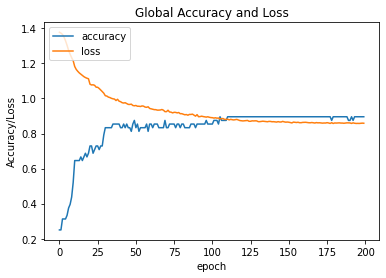

In [ ]:
_visualise(_case8Model, _case8Accuracy, _case8Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case8Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 93.191% | global_loss: 0.8141467571258545


CASE 9:
* Sharing deep weights every epoch, 4 shallow and 2 deep layers

In [ ]:
_case9Model, _case9Accuracy, _case9Loss  = _trainModel(1, 4, 6) 

comm_round: 0 | global_acc: 25.000% | global_loss: 1.3806085586547852
comm_round: 1 | global_acc: 29.167% | global_loss: 1.3763494491577148
comm_round: 2 | global_acc: 47.917% | global_loss: 1.3715232610702515
comm_round: 3 | global_acc: 54.167% | global_loss: 1.36544668674469
comm_round: 4 | global_acc: 54.167% | global_loss: 1.3548771142959595
comm_round: 5 | global_acc: 52.083% | global_loss: 1.3372708559036255
comm_round: 6 | global_acc: 52.083% | global_loss: 1.3142811059951782
comm_round: 7 | global_acc: 54.167% | global_loss: 1.2903207540512085
comm_round: 8 | global_acc: 56.250% | global_loss: 1.266659140586853
comm_round: 9 | global_acc: 62.500% | global_loss: 1.2431105375289917
comm_round: 10 | global_acc: 62.500% | global_loss: 1.2219135761260986
comm_round: 11 | global_acc: 60.417% | global_loss: 1.2012747526168823
comm_round: 12 | global_acc: 64.583% | global_loss: 1.183040738105774
comm_round: 13 | global_acc: 64.583% | global_loss: 1.166580319404602
comm_round: 14 | glob

2022-06-12 22:57:27.731276: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


comm_round: 99 | global_acc: 89.583% | global_loss: 0.880395233631134
comm_round: 100 | global_acc: 91.667% | global_loss: 0.872312068939209
comm_round: 101 | global_acc: 91.667% | global_loss: 0.8771799206733704
comm_round: 102 | global_acc: 91.667% | global_loss: 0.8775660991668701
comm_round: 103 | global_acc: 89.583% | global_loss: 0.8747158050537109
comm_round: 104 | global_acc: 91.667% | global_loss: 0.8719373345375061
comm_round: 105 | global_acc: 91.667% | global_loss: 0.8723812699317932
comm_round: 106 | global_acc: 91.667% | global_loss: 0.87107253074646
comm_round: 107 | global_acc: 89.583% | global_loss: 0.8714830279350281
comm_round: 108 | global_acc: 91.667% | global_loss: 0.8701592087745667
comm_round: 109 | global_acc: 91.667% | global_loss: 0.8682863116264343
comm_round: 110 | global_acc: 91.667% | global_loss: 0.8695430755615234
comm_round: 111 | global_acc: 91.667% | global_loss: 0.866166889667511
comm_round: 112 | global_acc: 91.667% | global_loss: 0.867998123168945

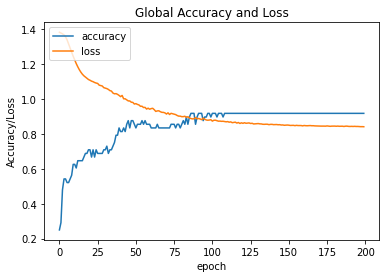

In [ ]:
_visualise(_case9Model, _case9Accuracy, _case9Loss)

In [ ]:
test_acc = list()
test_loss = list()
for (X_test, Y_test) in test_batched:
    global_test_acc, global_test_loss = test_model(X_test, Y_test, _case9Model, comm_round=1)
    test_acc.append(global_test_acc)
    test_loss.append(global_test_loss)

comm_round: 1 | global_acc: 92.716% | global_loss: 0.8158657550811768
